Data Points: 2748 

Excerpt data set:
                                              Phrase  Sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1 



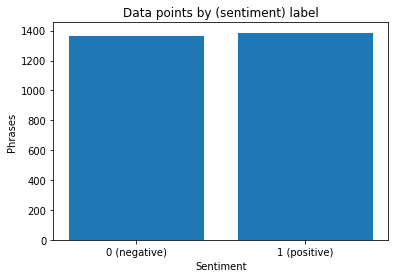

In [1]:
import tensorflow as tf
import pandas as pd
import os
import glob

zip_file = tf.keras.utils.get_file('sentiment%20labelled%20sentences.zip', 
                                 'https://github.com/stefanfausser/Business_School_HNU/raw/master/sentiment%20labelled%20sentences.zip',
                                 extract=True)
path = os.path.dirname(zip_file) + "/sentiment labelled sentences/"
all_files = sorted(glob.glob(os.path.join(path, '*_labelled.txt')))
df = pd.concat((pd.read_csv(f, sep='\t', names=['Phrase','Sentiment']) for f in all_files), ignore_index=True)
print("Data Points:", len(df), "\n")
print("Excerpt data set:")
print(df.head(), "\n")

%matplotlib inline
from matplotlib import pyplot as plt 
Sentiment_count = df.groupby('Sentiment').count()
plt.bar(['0 (negative)', '1 (positive)'], Sentiment_count['Phrase'])
plt.title("Data points by (sentiment) label")
plt.xlabel('Sentiment')
plt.ylabel('Phrases')
plt.show()

In [2]:
import random
random.seed(777)

# 80% training, 20% test
train_size = int(df.shape[0] * .8)
s = random.sample(range(df.shape[0]), df.shape[0])
df_train = df.iloc[s[:train_size]]
df_test = df.iloc[s[train_size:]]
print("Training data points: ", len(df_train))
print("Testing data points: ", len(df_test))
# print([len(df_train), len(df_test)])

Training data points:  2198
Testing data points:  550


In [3]:
# Tokenize phrases, up to 1000 words in corpus
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(df_train['Phrase'])
print("Excerpt corpus:")
print(tokenizer.index_word[1], tokenizer.index_word[100], tokenizer.index_word[300], tokenizer.index_word[1000])

Excerpt corpus:
the excellent problem stunning


In [4]:
matrix_train = tf.convert_to_tensor(tokenizer.texts_to_matrix(df_train['Phrase'], mode = "binary"), tf.float32)
matrix_test = tf.convert_to_tensor(tokenizer.texts_to_matrix(df_test['Phrase'], mode = "binary"), tf.float32)
y_train = tf.convert_to_tensor(df_train['Sentiment'].to_numpy().reshape((-1,1)), tf.float32)
y_test = tf.convert_to_tensor(df_test['Sentiment'].to_numpy().reshape((-1,1)), tf.float32)

print("Dimension of training matrix (data points x features):")
print(matrix_train.shape, "\n")
print("First sentence:")
print(df_train['Phrase'][0], "\n")
print("Number of found words, first sentence:")
print(sum(matrix_train[0].numpy()))

Dimension of training matrix (data points x features):
(2198, 1000) 

First sentence:
So there is no way for me to plug it in here in the US unless I go by a converter. 

Number of found words, first sentence:
11.0


In [5]:
# Set model weights
rni = tf.random_normal_initializer(mean = 0.0, stddev = 0.05, seed = 777)
W = tf.Variable(rni(shape = (matrix_train.shape[1], 1)))
b = tf.Variable(tf.zeros([1]))

#@tf.function
def model_logits(X):
    return tf.linalg.matmul(X, W) + b

#@tf.function
def model(X):
    return 1.0 / (1.0 + tf.exp(-model_logits(X)))

# (stochastic) gradient descent
opt = tf.keras.optimizers.SGD(learning_rate=3)

alpha = 0
loss_fn = lambda: - tf.math.reduce_mean(
    ys * tf.math.log(model(xs))
    + (1.0 - ys) * tf.math.log(1.0 - model(xs))) + alpha * tf.math.reduce_mean(tf.math.abs(W))

In [6]:
def calculate_binary_confusion_matrix(x, y_true, threshold=0.5):
    y_pred_raw = model(x)
    def update_and_return_value(m, y_true, y_pred_raw):
        m.update_state(y_true, y_pred_raw)
        return m.result().numpy()        
    tp = update_and_return_value(tf.keras.metrics.TruePositives(thresholds = threshold), y_true, y_pred_raw)
    fp = update_and_return_value(tf.keras.metrics.FalsePositives(thresholds = threshold), y_true, y_pred_raw)
    fn = update_and_return_value(tf.keras.metrics.FalseNegatives(thresholds = threshold), y_true, y_pred_raw)
    tn = update_and_return_value(tf.keras.metrics.TrueNegatives(thresholds = threshold), y_true, y_pred_raw)
    return tf.convert_to_tensor([[tp, fp],[fn, tn]])

def calculate_metrics_from_binary_confusion_matrix(C):
    [[tp, fp], [fn, tn]] = C.numpy()    
    accuracy = round((tp + tn) / (tp + fp + tn + fn) * 100, 2)
    sensitivity = round(tp / (tp + fn) * 100, 2)
    specificity = round(tn / (tn + fp) * 100, 2)
    return {'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity}

print("Model performance with randomly initialized weights (has not learned anything!):\n")
print("Confusion matrix [[tp, fp], [fn, tn]]:")
C = calculate_binary_confusion_matrix(matrix_test, y_test)
print(C.numpy(), "\n")
print("Metrics:")
print(calculate_metrics_from_binary_confusion_matrix(C))

Model performance with randomly initialized weights (has not learned anything!):

Confusion matrix [[tp, fp], [fn, tn]]:
[[125. 102.]
 [171. 152.]] 

Metrics:
{'accuracy': 50.36, 'sensitivity': 42.23, 'specificity': 59.84}


In [7]:
# Train model
iterations = 300
# batch_size = int(matrix_train.shape[0] / 2) # 2 batches
batch_size = matrix_train.shape[0] # 1 batch
losses = []
for _ in range(iterations): 
    for i in range(0, matrix_train.shape[0], batch_size): 
        xs = matrix_train[i:i+batch_size, :]
        ys = y_train[i:i+batch_size]
        opt.minimize(loss_fn, var_list=[W,b])
        losses.append(loss_fn().numpy())

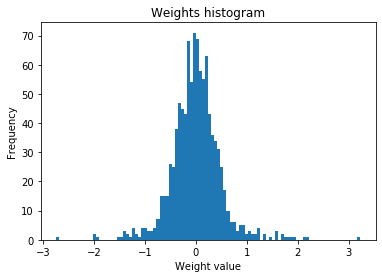

In [8]:
# How many zero weights?
from matplotlib import pyplot as plt 
plt.hist(W.numpy(), bins = 100) 
plt.title("Weights histogram") 
plt.xlabel('Weight value')
plt.ylabel('Frequency')
plt.show()

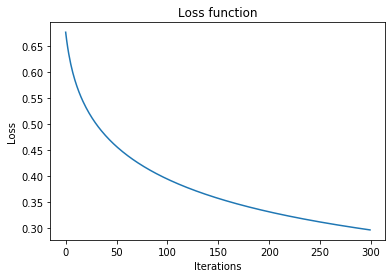

In [9]:
# Stable updates?
from matplotlib import pyplot as plt 
plt.plot(losses) 
plt.title("Loss function")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [10]:
print("Model performance:\n")
print("Confusion matrix [[tp, fp], [fn, tn]]:")
C = calculate_binary_confusion_matrix(matrix_test, y_test, threshold = 0.5)
print(C.numpy(), "\n")
print("Metrics:")
print(calculate_metrics_from_binary_confusion_matrix(C))

Model performance:

Confusion matrix [[tp, fp], [fn, tn]]:
[[224.  50.]
 [ 72. 204.]] 

Metrics:
{'accuracy': 77.82, 'sensitivity': 75.68, 'specificity': 80.31}


In [11]:
phrases = ['this is my day', 'is this my day?', 'this is a great day!', 'this is not a great day', 'this is so not my day!!']
matrix = tf.convert_to_tensor(tokenizer.texts_to_matrix(phrases, mode = "binary"), tf.float32)
print("Applying the model to further phrases:\n")
print(model(matrix))

Applying the model to further phrases:

tf.Tensor(
[[0.60729307]
 [0.60729307]
 [0.97443444]
 [0.8406795 ]
 [0.250483  ]], shape=(5, 1), dtype=float32)
